# Generate forcing datasets for FIESTY from the CESM-DPLE experiments

In [12]:
import os
from glob import glob

import matplotlib.colors as colors

import numpy as np
import xarray as xr
import pop_tools

### First get one year of data to find CA current region to subset

In [13]:
case = 'g.e22.G1850ECO_JRA_HR.TL319_t13.004'
path = '/glade/campaign/cesm/development/bgcwg/projects/hi-res_JRA/cases/' + case + '/output/ocn/proc/tseries/month_1'
variables = ['diatC']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']

In [14]:
%%time

#ds_ann = xr.Dataset()

#for year in np.arange(1,2,1):
year = 1
yr4="{:02d}".format(year)
v = variables[0]
files = sorted(glob(f'{path}/{case}.pop.h.{v}.00{yr4}01-00{yr4}12.nc'))
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True) #,preprocess=preprocess)


ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
ds = ds.mean(dim='time')

CPU times: user 49.4 ms, sys: 17.1 ms, total: 66.5 ms
Wall time: 612 ms


In [15]:
ds

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, z_t: 62, z_t_150m: 15)
Coordinates:
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, z_t, z_t_150m
Data variables:
    dz       (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    diatC    (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>

/glade/work/kristenk/miniconda/envs/analysis4/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


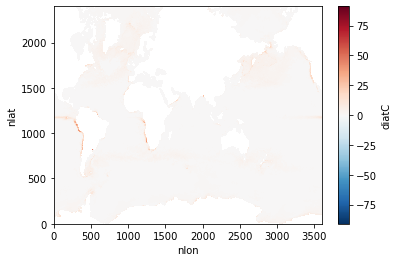

In [16]:
ds.diatC.isel(z_t_150m=0).plot()

In [17]:
ds_subset = ds.isel(nlat=slice(1480,1850),nlon=slice(3300,3600))

/glade/work/kristenk/miniconda/envs/analysis4/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


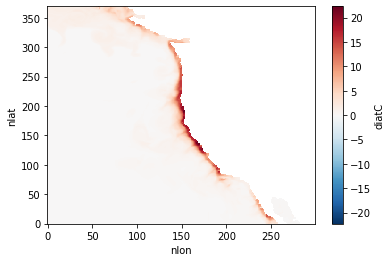

In [18]:
ds_subset.diatC.isel(z_t_150m=0).plot()

In [19]:
ds_subset

<xarray.Dataset>
Dimensions:  (nlat: 370, nlon: 300, z_t: 62, z_t_150m: 15)
Coordinates:
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(370, 300), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(370, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, z_t, z_t_150m
Data variables:
    dz       (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT      (nlat, nlon) float64 dask.array<chunksize=(370, 300), meta=np.ndarray>
    diatC    (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 370, 300), meta=np.ndarray>

### Now make preprocessing function to subset the data when reading it in

In [20]:
def preprocess(ds):
    ds=ds.isel(nlat=slice(1480,1850),nlon=slice(3300,3600))
    return ds

### Grab the first year of monthly data and then concat the rest of the years onto it

In [21]:
variables = ['diazC','TEMP', 'zooC', 'zoo_loss_zint_100m', 'diatC', 'spC', 'coccoC', 'POC_FLUX_IN']
keep_vars = variables + list(coords.values())+['dz','KMT']

year = 1
yr4="{:02d}".format(year)
print(year)
ds_tmp1 = xr.Dataset()

for v in variables:  
    #print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.00{yr4}01-00{yr4}12.nc'))
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

    ds_tmp1 = xr.merge((ds_tmp1, dsv))

ds_tmp1 = ds_tmp1.drop([v for v in ds_tmp1.variables if v not in keep_vars]).squeeze()

1


In [22]:
%%time

variables = ['diazC','TEMP', 'zooC', 'zoo_loss_zint_100m', 'diatC', 'spC', 'coccoC', 'POC_FLUX_IN']
keep_vars = variables + list(coords.values())+['dz','KMT']

ds = xr.Dataset()

for year in np.arange(2,35,1):
    yr4="{:02d}".format(year)
    print(year)
    ds_tmp = xr.Dataset()
    for v in variables:  
        #print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.00{yr4}01-00{yr4}12.nc'))
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

        ds_tmp = xr.merge((ds_tmp, dsv),compat='override')

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars]).squeeze()
    
    ## add it to the annual file
    if year == 2:
        ds = xr.concat([ds_tmp1, ds_tmp], "time")
    else:
        ds = xr.concat([ds,ds_tmp],"time")

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
CPU times: user 14.8 s, sys: 509 ms, total: 15.3 s
Wall time: 40.3 s


In [23]:
ds

<xarray.Dataset>
Dimensions:             (nlat: 370, nlon: 300, time: 408, z_t: 62, z_t_150m: 15)
Coordinates:
    TLONG               (time, nlat, nlon) float64 dask.array<chunksize=(36, 370, 300), meta=np.ndarray>
    TLAT                (time, nlat, nlon) float64 dask.array<chunksize=(36, 370, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, time, z_t, z_t_150m
Data variables:
    dz                  (time, z_t) float32 dask.array<chunksize=(12, 62), meta=np.ndarray>
    KMT                 (time, nlat, nlon) float64 dask.array<chunksize=(12, 370, 300), meta=np.ndarray>
    diazC               (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(12, 15, 370, 300), meta=np.ndarray>
    TEMP                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 62, 370, 300), meta=np.ndarray>
    zooC                (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(12, 15, 370, 300), meta=np.ndarray>
    zoo_loss_zint_100m  (time, nlat, nlon) float32 dask.array<chunksize=(12, 370, 300), meta=np.ndarray>
    diatC               (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(12, 15, 370, 300), meta=np.ndarray>
    spC                 (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(12, 15, 370, 300), meta=np.ndarray>
    coccoC              (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(12, 15, 370, 300), meta=np.ndarray>
    POC_FLUX_IN         (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 62, 370, 300), meta=np.ndarray>

In [24]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
ds_grid= ds_grid.isel(nlat=slice(1480,1850),nlon=slice(3300,3600))

## Spin up a dask cluster

In [25]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='256GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=256GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(8) 

In [26]:
client

Client Scheduler: tcp://10.12.206.59:35245 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Compute forcing datasets

Inialize outout dataset

In [27]:
%%time
USER = os.environ['USER']
dout = f'/glade/work/{USER}/fish-offline'
os.makedirs(dout, exist_ok=True)

dso = ds[['TLONG', 'TLAT', 'KMT']]
dso

CPU times: user 654 µs, sys: 0 ns, total: 654 µs
Wall time: 693 µs


<xarray.Dataset>
Dimensions:  (nlat: 370, nlon: 300, time: 408)
Coordinates:
    TLONG    (time, nlat, nlon) float64 dask.array<chunksize=(36, 370, 300), meta=np.ndarray>
    TLAT     (time, nlat, nlon) float64 dask.array<chunksize=(36, 370, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, time
Data variables:
    KMT      (time, nlat, nlon) float64 dask.array<chunksize=(12, 370, 300), meta=np.ndarray>

### Compute upper 1000 m means/integrals

In [28]:
def field_100m_mean(da):
    """compute mean over upper 100 m; assume constant dz"""
    depth_slice = slice(0, 10)
    with xr.set_options(keep_attrs=True):
        if 'z_t' in da.dims:
            return da.isel(z_t=depth_slice).mean('z_t')
        elif 'z_t_150m' in da.dims:
            return da.mean('z_t_150m')
def field_100m_zint(da, dz):
    """compute integral over upper 100 m; assume constant dz"""
    depth_slice = slice(0, 100e2)
    with xr.set_options(keep_attrs=True):
        if 'z_t' in da.dims:            
            dao = (dz * da).sel(z_t=depth_slice).sum('z_t')
        elif 'z_t_150m' in da.dims:
            dao = (dz.isel(z_t=slice(0, 10)).rename({'z_t': 'z_t_150m'}) * da.isel(z_t_150m=slice(0, 10))).sum('z_t_150m')
    dao.attrs['units'] = da.attrs['units'] + ' cm'        
    return dao

In [29]:

        
# def field_100m_zint(da, dz):
#     """compute integral over upper 100 m; assume constant dz"""
#     depth_slice = slice(0, 100e2)
#     with xr.set_options(keep_attrs=True):
#         if 'z_t' in da.dims:            
#             dao = (dz * da).sel(z_t=depth_slice).sum('z_t')
#         elif 'z_t_150m' in da.dims:
#             dz2 = dz.isel(z_t=slice(0, 15)).rename({'z_t': 'z_t_150m'})
#             dao = (dz2.isel(z_t_150m=slice(0,10)) * da.isel(z_t_150m=slice(0,10))).sum('z_t_150m')
#     dao.attrs['units'] = da.attrs['units'] + ' cm'        
#     return dao 

In [30]:
%%time
for v in ['TEMP',]:
    dso[f'{v}_100m'] = field_100m_mean(ds[v]).compute()  

CPU times: user 1.48 s, sys: 929 ms, total: 2.41 s
Wall time: 30.2 s


In [31]:
%%time
for v in ['diazC','zooC', 'diatC', 'spC', 'coccoC']:
    print(v)
    dso[f'{v}_100m'] = field_100m_zint(ds[v], ds.dz).compute()     

diazC
zooC
diatC
spC
coccoC
CPU times: user 6.24 s, sys: 3.34 s, total: 9.57 s
Wall time: 1min 45s


Check output

In [32]:
dso = dso.where(ds_grid.REGION_MASK>0)

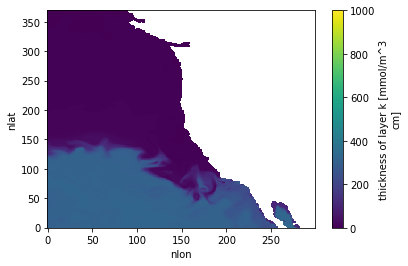

In [33]:
dso.diazC_100m.isel(time=0).plot(vmin=0, vmax=1000)

## Compute properties at model bottom

In [34]:
KMT = ds_grid.KMT.compute()
KMT

<xarray.DataArray 'KMT' (nlat: 370, nlon: 300)>
array([[58, 58, 58, ...,  0,  0,  0],
       [58, 58, 58, ...,  0,  0,  0],
       [58, 58, 58, ...,  0,  0,  0],
       ...,
       [52, 52, 52, ...,  0,  0,  0],
       [52, 52, 52, ...,  0,  0,  0],
       [52, 52, 52, ...,  0,  0,  0]], dtype=int32)
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    k Index of Deepest Grid Cell on T Grid
    coordinates:  TLONG TLAT

In [35]:
def field_at_bottom(da):
    """return a field indexed at the model's bottom layer"""

    tmp_bot = xr.DataArray(np.ones(da[:, 0, :, :].shape) * np.nan, 
                           dims=tuple(da.dims[i] for i in [0, 2, 3]),
                           #coords={c: da.coords[c] for c in ['time']},
                          )
    print('made tmp bot')
    assert KMT.shape == da.shape[-2:]
    print('asserted KMT')
    for j in range(len(da.nlat)):
        for i in range(len(da.nlon)):
            if KMT[j, i] > 0:
                k = int(KMT[j, i] - 1)
                tmp_bot.values[:, j, i] = da[:, k, j, i]
    return tmp_bot

In [36]:
ds = ds.unify_chunks()

In [37]:
%%time
for v in ['TEMP', 'POC_FLUX_IN',]:
    print(v)
    template = ds[v][:, 0, :, :].drop(['TLAT','TLONG']) #.drop('z_t') 
    dso[f'{v}_bottom'] = xr.map_blocks(
        field_at_bottom, ds[v], 
        template=template
    ).compute()

TEMP
POC_FLUX_IN
CPU times: user 7.33 s, sys: 2.21 s, total: 9.54 s
Wall time: 5min 4s


### Add HT

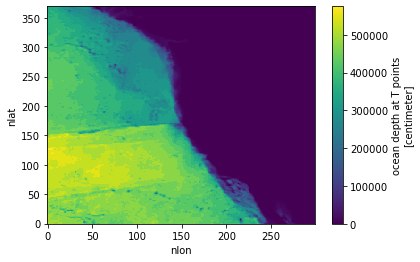

In [38]:
HT = xr.full_like(ds_grid.TAREA, fill_value=0.)
HT.attrs = dict(
    units='centimeter',
    long_name='ocean depth at T points',
    note='this field ignores overflows, which comprise isolated KMT pop-down points'
)
for j in range(len(ds_grid.nlat)):
    for i in range(len(ds_grid.nlon)):
        if ds_grid.KMT[j, i] > 0:
            k = int(ds_grid.KMT[j, i] - 1)
            HT.values[j, i] = ds_grid.z_w_bot[k]
            
ds['HT'] = HT
HT.plot()

In [40]:
dso['HT'] = HT

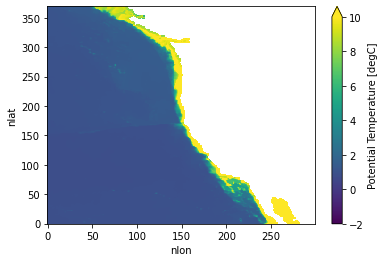

In [42]:
dso.TEMP_bottom.isel(time=0).plot(vmin=-2, vmax=10.)

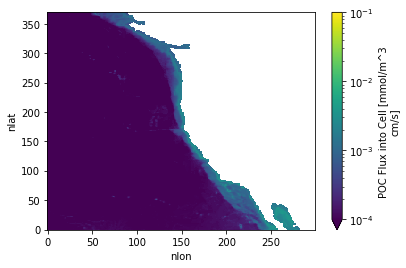

In [43]:
dso.POC_FLUX_IN_bottom.isel(time=0).plot(norm=colors.LogNorm(vmin=1e-4, vmax=0.1))

### Just add on the zoo_loss_zint_100m

In [44]:
dso['zoo_loss_100m'] = ds.zoo_loss_zint_100m

## Write output file

In [45]:
%%time
dso.to_netcdf(f'{dout}/{case}.FIESTY-forcing_hiresJRA_CAcurr.nc', mode='w')

CPU times: user 6.27 s, sys: 912 ms, total: 7.18 s
Wall time: 41.2 s


In [47]:
f'{dout}/{case}.FIESTY-forcing_hiresJRA_CAcurr.nc'

'/glade/work/kristenk/fish-offline/g.e22.G1850ECO_JRA_HR.TL319_t13.004.FIESTY-forcing_hiresJRA_CAcurr.nc'

In [48]:
dso

<xarray.Dataset>
Dimensions:             (nlat: 370, nlon: 300, time: 408)
Coordinates:
    TLONG               (time, nlat, nlon) float64 dask.array<chunksize=(36, 370, 300), meta=np.ndarray>
    TLAT                (time, nlat, nlon) float64 dask.array<chunksize=(36, 370, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, time
Data variables:
    KMT                 (time, nlat, nlon) float64 dask.array<chunksize=(12, 370, 300), meta=np.ndarray>
    TEMP_100m           (time, nlat, nlon) float32 20.68 20.69 20.68 ... nan nan
    diazC_100m          (time, nlat, nlon) float32 304.1 303.8 303.5 ... nan nan
    zooC_100m           (time, nlat, nlon) float32 3.088e+03 3.081e+03 ... nan
    diatC_100m          (time, nlat, nlon) float32 887.8 888.3 888.6 ... nan nan
    spC_100m            (time, nlat, nlon) float32 3.256e+03 3.255e+03 ... nan
    coccoC_100m         (time, nlat, nlon) float32 415.6 414.6 413.7 ... nan nan
    TEMP_bottom         (time, nlat, nlon) float64 0.8775 0.8778 ... nan nan
    POC_FLUX_IN_bottom  (time, nlat, nlon) float64 8.908e-05 8.892e-05 ... nan
    HT                  (nlat, nlon) float64 5e+05 5e+05 5e+05 ... 0.0 0.0 0.0
    zoo_loss_100m       (time, nlat, nlon) float32 dask.array<chunksize=(12, 370, 300), meta=np.ndarray>